In [1]:
import os
import gc
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import sympy as sp

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50V2, ResNet50
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
from tensorflow.keras.applications import EfficientNetB0
from keras.models import load_model
import cv2
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using {} device".format(device))

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

C:\ProgramData\Anaconda3\envs\idip_2021\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using cuda device
Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [2]:
def padding(img):
    h,w,c = img.shape
    
    set_size = max(h,w)
    
    if (h >w):
        delta_w = set_size -w
        delta_h = h - set_size
    elif (h < w):
        delta_w = w - set_size
        delta_h = set_size -h
    elif (h == w ):
        return img
    
    top,bottom = delta_h//2 , delta_h-(delta_h//2)
        
    left , right = delta_w //2 , delta_w -(delta_w //2)
        
    new_img = cv2.copyMakeBorder(img,top,bottom,left,right,cv2.BORDER_CONSTANT,value = [0,0,0])
    
    return new_img    

In [6]:
images = sorted(glob.glob('./examples/*.png'))#test image를 모두 불러와 pre-processing하는 과정
z = 1
for k in images:
    s = plt.imread(k)
    s = s[:,:,2] * 255
    s = 255-s
    for a in range(len(s)):
        for b in range(len(s[0,:])):
            if s[a,b]<50:
                s[a,b]=0
    
    
    new_s = np.zeros((s.shape[0] , s.shape[1] + 10))
    new_s[:,:-10] = s
    
    i = 0
    j = 0
    
    
    for j in range(len(new_s[0,:])-1):
        if (new_s[:,j]==0).all() and (new_s[:,j+1]>0).any():
          
            for i in range(j+1,len(new_s[0,:])-1):
                if (new_s[:,i]>0).any() and (new_s[:,i+1]==0).all() :
                    img1 = new_s[:, j:i]
                    cv2.imwrite('./examples/cut_imgs/%d/a%d.png' % ( z ,i ) , img1)
                  
    z = z+1  

['./examples\\s1.PNG', './examples\\s2.PNG', './examples\\s3.PNG', './examples\\s4.PNG', './examples\\s5.PNG', './examples\\s6.PNG', './examples\\s7.png', './examples\\s8.png']


In [4]:
y = 0
z = 1
for y in range(6):
    
    imgs = sorted(glob.glob('./examples/cut_imgs/%d/*'%(y+1)), key=os.path.getctime)
    z = 1
                         
    for l in imgs:
        org = plt.imread(l)
        org = org*255
        new = np.zeros((org.shape[0]+10 , org.shape[1]))
        new[5:-5,:] = org
       
        e = 0
        f = 1
        
        for f in range(len(new)-1):
            if (new[f,:]==0).all() and (new[f+1,:]>0).any():
                start = f
                for e in range(len(new)-1):
                    if (new[-(e+1),:]==0).all() and (new[-(e+2),:]>0).any() :
                        end = len(new) - e                      
                        break
                break        
                        
        org1 = new[start-1:end+1 ,]
        cv2.imwrite('./examples/slicing_imgs/%d/%d.png' % ( y+1 , z ) , org1)
        z = z+1
        

In [3]:
test = sorted(glob.glob('./examples/slicing_imgs/4/*.png'), key=os.path.getctime)  #split한 test image들을 불러옴
X =[]
for prd in test:
    data = cv2.imread(prd)
    data = padding(data)
    data = data[:,:,2]
    data = cv2.resize(data, dsize=(28, 28),interpolation=cv2.INTER_CUBIC)
    X.append(data) # 각각의 image data를 갖는 X배열 생성
    
    
X = [cv2.resize(image, (32, 32)) for image in X] # model에 넣기 위한 data 변환과정
X = np.array(X, dtype="float32")
X = np.expand_dims(X, axis=-1)
X /= 255.0


In [4]:
print(X.shape)

(13, 32, 32, 1)


In [10]:
model_all = load_model('Restnet_all.h5')
#model_multi = load_model('Resnet_multi.h5')
#model_A_Z = load_model('Resnet_Big.h5')
#model_mnist = load_model('Resnet_mnist.h5')
#model_a_z = load_model('ResNet_small.h5')
#model_Index = load_model('ResNet_index.h5')

In [6]:
print(X.shape)

(13, 32, 32, 1)


In [7]:
Index = ["/" , "=" , "!" , "Integral" ,"[" , ">=" , ">" , "{" , "(" , "-" , "*","+","]","<=","<","}",")"]

In [11]:
y_hat = model_all.predict(X)#test image의 target값을 predict
target = []
# target값을 정수형으로 반환
for i in range(len(y_hat)):
    target.append(np.argmax(y_hat[i]))

for j in range(len(target)):
    if target[j] <10:
        target[j] = "%d" % target[j]
    
    elif (9 < target[j] and target[j] <62):
        target[j] = "%c" %(55+target[j])
        
    elif target[j] >61:
        target[j] = Index[target[j]-62]
        
    else:
        print("out of bound")
        
# 0~9 : 숫자
# 10~35 : 대문자 Alphabet A~Z
# 36~61 : 소문자 Alphabet a~z
# 62~78 : 기호  /, =, ! , integral, [ ,>=, > , { , ( , - , * , + , ] , <= , < , } , ) 
# 총 79개의 Index

In [12]:
print(target) # 0: 숫자  1: 대문자  2: 소문자  3:  특수문자 

['{', 'f', '1', 'X', '-', '(', '2', 'k', '/', '3', ')', '}', '=']


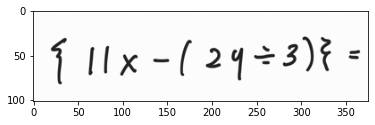

In [13]:
test_img = plt.imread('./examples/s4.png')
plt.imshow(test_img)

In [16]:
target = target[:-1]
print(target)

['{', 'f', '1', 'X', '-', '(', '2', 'k', '/', '3', ')', '}']


In [17]:
function=['cos','sin','tan','f(x)','log','ln','C','P','e','cosh','sinh','tanh','integral','i']

spfunction=['sp.cos','sp.sin','sp.tan','f(x)','log','ln','C','P','sp.exp','sp.cosh','sp.sinh','sp.tanh','integrate','sp.I']

function2=['cos','sin','tan','cosh','sinh','tanh','log','ln']

num = ['0','1','2','3','4','5','6','7','8','9']

small_letter = ["a","b","c", "d","e","f","g", "h","i","j","k", "l","m","n","o", "p","q","r","s", "t","u","v","w", "x","y","z"]

large_letter = ["A","B","C", "D","E","F","G", "H","I","J","K", "L","M","N","O", "P","Q","R","S", "T","U","V","W", "X","Y","Z"]

letter = ["a","b","c", "d","e","f","g", "h","i","j","k", "l","m","n","o", "p","q","r","s", "t","u","v","w", "x","y","z","A","B","C", "D","E","F","G", "H","I","J","K", "L","M","N","O", "P","Q","R","S", "T","U","V","W", "X","Y","Z"]

bracket = ["[","{","(",")","}","]"]

In [18]:
target1=''.join(target)
string=[]
count=len(target1)

# function algorithm
while count>0:
    for i in range (len(target1)):
            for j in range (len(function)):
                if target1[:-i]==function[j]:
                    string = np.append(string,target1[:-i])
                    target1=target1[-i:]
                    count=count-(len(target1)-i)
                    i=0
            
                elif (len(target1[:-i])==1):
                    string=np.append(string,target1[:-i])
                    target1=target1[-i:]
                    count=count-1
                    i=0
                
                elif (len(target1)==1):
                    string=np.append(string,target1)
                    target1=[]
                    count=0

In [19]:
string1=[]
string2=[]
string3=[]
string4=[]
string5=[]
string6=[]
string7=[]
string8=[]
# integral to integrate
for j in range(len(string)):
    if string[j]=="integral" and string[j+1]=="(":
        string[j]="integrate"
        for i in range(len(string)):
            if string[i]==")" and string[i+1]=="d":
                string1=np.append(string[:j+1],"(")
                string[i+1]=","
                string2=np.append(string[j+1:i+3],")")
                string3=np.append(string1,string2)
                string=np.append(string3,string[i+3:])
                break
    elif string[j]=="i":
        string[i]="I"
    elif string[j]=="log":
        for h in range(j,len(string)):
            if string[h]=="(":
                for k in range(h,len(string)):
                    if string[k]==")":
                        string4=np.append(string[:j+1],string[h:k])
                        string5=np.append(",",string[j+1:h])
                        string6=np.append(string4,string5)
                        string=np.append(string6,string[k:])
                        break
                break

In [20]:
string1=[]

for i in range(len(string)-1):
    #알파벳 뒤에 숫자
    for j in range(len(letter)):
        for k in range(len(num)):
            if (letter[j] == string[i]) and (num[k]==string[i+1]):
                string1=np.append(string[:i+1],['*'])
                string=np.append(string1,string[i+1:])
            
for i in range(1,len(string)):
    #알파벳 앞에 숫자
    for j in range(len(letter)):
        for k in range(len(num)):
            if (letter[j] == string[i]) and (num[k]==string[i-1]):
                string1=np.append(string[:i],['*'])
                string=np.append(string1,string[i:])

In [21]:
string1=[]
string2=[]
for i in range(len(string)-1):
    for j in range(len(letter)):
        if (letter[j] == string[i]) and (string[i+1]==bracket[0]):
            string1=np.append(string[:i+1],['*'])
            string=np.append(string1,string[i+1:])
                
        elif (letter[j] == string[i]) and (string[i+1]==bracket[1]):
            string1=np.append(string[:i+1],['*'])
            string=np.append(string1,string[i+1:])
            
        elif (letter[j] == string[i]) and (string[i+1]==bracket[2]):
            string1=np.append(string[:i+1],['*'])
            string=np.append(string1,string[i+1:])
    
    for k in range(len(num)):
        if (num[k] == string[i]) and (string[i+1]==bracket[0]):
            string2=np.append(string[:i+1],['*'])
            string=np.append(string2,string[i+1:])
                
        elif (num[k] == string[i]) and (string[i+1]==bracket[1]):
            string2=np.append(string[:i+1],['*'])
            string=np.append(string2string[i+1:])
            
        elif (num[k] == string[i]) and (string[i+1]==bracket[2]):
            string2np.append(string[:i+1],['*'])
            string=np.append(string2string[i+1:])

In [22]:
string1=[]

for i in range(1,len(string)):
    for j in range(len(letter)):
        if (letter[j] == string[i]) and (string[i-1]==bracket[3]):
            string1=np.append(string[:i],['*'])
            string=np.append(string1,string[i:])
                
        elif (letter[j] == string[i]) and (string[i-1]==bracket[4]):
            string1=np.append(string[:i],['*'])
            string=np.append(string1,string[i:])
            
        elif (letter[j] == string[i]) and (string[i-1]==bracket[5]):
            string1=np.append(string[:i],['*'])
            string=np.append(string1,string[i:])
    
    for k in range(len(num)):
        if (num[k] == string[i]) and (string[i-1]==bracket[3]):
            string1=np.append(string[:i],['*'])
            string=np.append(string1,string[i:])
                
        elif (num[k] == string[i]) and (string[i-1]==bracket[4]):
            string1=np.append(string[:i],['*'])
            string=np.append(string1,string[i:])
            
        elif (num[k] == string[i]) and (string[i-1]==bracket[5]):
            string1=np.append(string[:i],['*'])
            string=np.append(string1,string[i:])

In [23]:
#문자 문자 곱셈
for i in range(len(string)-1):
    for j in range(len(letter)):
        for k in range(len(letter)):
            if (string[i]==letter[j])and(string[i+1]==letter[k]):
                string1=[]
                string1=np.append(string[:i+1],index[10])
                string=np.append(string1,string[i+1:])

In [24]:
#sympy 사용전 수식화
arr=''.join(string)
arr2=[]
arr2=np.append(arr2,arr)

In [25]:
#sympy 변수지정 : C P i e 네개 제외
a,b,c,d,f,g,h,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,A,B,D,E,F,G,H,I,J,K,L,M,N,O,Q,R,S,T,U,V,W,X,Y,Z = sp.symbols("a b c d f g h j k l m n o p q r s t u v w x y z A B D E F G H I J K L M N O Q R S T U V W X Y Z")

In [26]:
#식 변환 
expr=sp.sympify(arr2[0])
print( expr )

{X*f - 2*k/3}


In [28]:
exprk = sp.simplify(expr)
exprk

{X*f - 2*k/3}

In [30]:
type(exprk)

sympy.sets.sets.FiniteSet